<a href="https://colab.research.google.com/github/LeeYoungJun1113/Thesis___/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

## 내 드라이브에 코랩이 호환 하게함하게함

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:


# 다운그레이드 예시
!pip install --upgrade tensorflow==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86.3 MB 31 kB/s 
     |████████████████████████████████| 449 kB 31.8 MB/s 
     |████████████████████████████████| 3.8 MB 36.2 MB/s 
     |████████████████████████████████| 50 kB 3.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=45801383b3769e2892437d3c5675881aa77b74b3d4db8667f424ab2213de4e38
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uni

In [17]:
print(tf.__version__)

2.2.2


In [7]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
import random
import warnings
warnings.filterwarnings('ignore')

import cv2
import os
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import nibabel as nib

from pylab import rcParams

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

raw_data = pd.read_csv('/content/gdrive/MyDrive/K_THESIS/input/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/gdrive/MyDrive/K_THESIS/input/covid19-ct-scans/',regex=True)
raw_data.shape

(20, 4)

In [9]:
# Step for preprocessing images
# CLAHE Enhance to intensify the contrast of the CT images 
# because medical images suffer much from the contrast problems in clinical routine

def clahe_enhancer(img, demo=False):
  img = np.uint8(img*255)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
  clahe_img = clahe.apply(img)
  if demo:
    clahe_img_flattened = clahe_img.flatten()
    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10

    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap='bone')
    plt.title("Original CT-scan")

    plt.subplot(2, 2, 2)
    plt.hist(img_flattened)
    plt.title("Histogram of Original CT-Scan")
  
    plt.subplot(2, 2, 3)
    plt.imshow(clahe_img, cmap='bone')
    plt.title("CLAHE Enhanced CT-Scan")

    plt.subplot(2, 2, 4)
    plt.hist(clahe_img_flattened)
    plt.title("Histogram of CLAHE Enhanced CT-Scan")
    
  return clahe_img



In [10]:
# Cropping: Define a function to crop the lungs region in the lungs mask image

def cropper(test_img):
  
  test_img = test_img*255
  test_img = np.uint8(test_img)
  contours, hierarchy = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(c) for c in contours]
  x = np.argsort(areas)
  max_index = x[x.size - 1]
  cnt1=contours[max_index]
  second_max_index = x[x.size - 2]
  cnt2 = contours[second_max_index]

  x,y,w,h = cv2.boundingRect(cnt1)
  p,q,r,s = cv2.boundingRect(cnt2)
  cropped1 = test_img[y:y+h, x:x+w]
  cropped1 = cv2.resize(cropped1, dsize=(125,250), interpolation=cv2.INTER_AREA)
  cropped2 = test_img[q:q+s, p:p+r]
  cropped2 = cv2.resize(cropped2, dsize=(125,250), interpolation=cv2.INTER_AREA)

  if x < p:
    fused = np.concatenate((cropped1, cropped2), axis=1)
  else:
    fused = np.concatenate((cropped2, cropped1), axis=1)

  points_lung1 = []
  points_lung2 = []
  points_lung1.append(x); points_lung1.append(y); points_lung1.append(w); points_lung1.append(h)
  points_lung2.append(p); points_lung2.append(q); points_lung2.append(r); points_lung2.append(s)

  return(fused, points_lung1, points_lung2)

In [11]:
# Load and prepare data
# Define a function to read .nii files
# Total slilces are 3520, which have been sliced out by 20% in the front and by 20% in the last of each file
# Since in general these didn't had any infection masks and some didn't had the lungs, removed as noise.
# Images had pixel vlaues in a very large range, so need to normalize the pixel values.

all_points1 = []
all_points2 = []

def read_nii(filepath, data, string):
  global all_points1
  global all_points2
  ct_scan = nib.load(filepath)
  array   = ct_scan.get_fdata()
  array   = np.rot90(np.array(array))
  slices  = array.shape[2]
  array   = array[:,:,round(slices*0.2):round(slices*0.8)]
  array   = np.reshape(np.rollaxis(array, 2), (array.shape[2], array.shape[0], array.shape[1], 1))

  if string == "lungs":
    all_points1 = []
    all_points2 = []

  for img_no in range(0, array.shape[0]):
    if string == 'lungs' and np.unique(array[img_no]).size == 1:
      continue
    img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
    # nomalize img
    xmax, xmin = img.max(), img.min()
    img = (img - xmin) / (xmax - xmin)

    if string == 'lungs':
      img[img>0]=1
      img, points1, points2 = cropper(img)
      all_points1.append((points1[0], points1[1], points1[2], points1[3]))
      all_points2.append((points2[0], points2[1], points2[2], points2[3]))
      continue

    if string == "cts" and img_no < len(all_points1):
      img = clahe_enhancer(img)
      a,b,c,d = all_points1[img_no]
      e,f,g,h = all_points2[img_no]
      img1 = img[b:b+d, a:a+c]
      img1 = cv2.resize(img1, dsize=(125,250), interpolation=cv2.INTER_AREA)
      img2 = img[f:f+h, e:e+g]
      img2 = cv2.resize(img2, dsize=(125,250), interpolation=cv2.INTER_AREA)
      if a<e:
        img = np.concatenate((img1, img2), axis =1)
      else:
        img = np.concatenate((img2, img1), axis=1)

    if string == "infections" and img_no < len(all_points1):
      a,b,c,d = all_points1[img_no]
      e,f,g,h = all_points2[img_no]
      img = np.uint8(img*255)
      img1 = img[b:b+d, a:a+c]
      img1 = cv2.resize(img1, dsize=(125, 250), interpolation=cv2.INTER_AREA)
      img2 = img[f:f+h, e:e+g]
      img2 = cv2.resize(img2, dsize=(125, 250), interpolation=cv2.INTER_AREA)
      if a<e:
        img = np.concatenate((img1, img2), axis=1 )
      else:
        img = np.concatenate((img2, img1), axis=1)
    img= cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
    data.append(img)


In [12]:
# Load image data
# We have 2112 CT scan images in total.

cts = []
lungs = []
infections = []
img_size = 224
for i in range(0, raw_data.shape[0]):
  read_nii(raw_data.loc[i,'lung_mask'], lungs, 'lungs')
  read_nii(raw_data.loc[i,'ct_scan'], cts, 'cts')
  read_nii(raw_data.loc[i,'infection_mask'], infections, 'infections')

print(len(cts), len(infections))

2112 2112


In [13]:
# Load Target Label

y_label = []
for i in range(0, len(infections)):
  if len(np.unique(infections[i]))!=1:
    y_label.append(1)
  else:
    y_label.append(0)
print(y_label.count(0), y_label.count(1))


498 1614


In [21]:
# Prepare the Data in the following steps:
# 1. Convert data to numpy array
# 2. Split data into training and validation data (0.7:0.3)
# 3. Set up data augmentation generator to diversity our data and avoid overfitting

# Convert to np array
cts = np.array(cts).astype('uint8')
cts = cts.reshape(len(cts), img_size, img_size, 1)
y_label = np.array(y_label)

# Split data
x_train, x_valid, y_train, y_valid = train_test_split(cts, y_label, test_size = 0.3, random_state=42)

# data augmentation
aug = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
    )


In [35]:
type(y_label)

numpy.ndarray

In [33]:
type(x_train)

numpy.ndarray

In [37]:
type(x_valid)

numpy.ndarray

In [39]:
type(y_train)

numpy.ndarray

In [41]:
# Build Model

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', padding="same", input_shape=(img_size,img_size,1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

batch_size = 32
epochs = 80
best_val_auc = -1

#model checkpoint
filepath_acc = "covid_weights_val_acc.hdf5"
checkpoint_acc = ModelCheckpoint(filepath_acc, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0003), metrics=["acc"])

In [ ]:
# Training Model
# Calulate the class weights due to unbalanced data

#weights = class_weight.compute_class_weight(class_weight = 'balanced', np.unique(y_train), y_train)
weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                   
                                    )

weights = dict(enumerate(weights))

# train model
results = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    validation_data=(x_valid, y_valid), 
                    steps_per_epoch = len(x_train)//batch_size,
                    callbacks = [checkpoint_acc],
                    class_weight=weights)

Epoch 1/80
46/46 [==============================] - ETA: 0s - loss: 1.5750 - acc: 0.5906WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fb8fd51d950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7fb8fd51d950>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the

In [31]:
# Model Performance by using validation data to evaluate
# Load the checkpoint with best validation accuracy
# See the test loss and accuracy from the output below

model.load_weights("covid_weights_val_acc.hdf5")
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss:" , score[0], "\ntest accuracy:" , score[1])

20/20 [==============================] - 25s 1s/step - loss: 0.5927 - acc: 0.7997
test loss: 0.592706561088562 
test accuracy: 0.7996845245361328


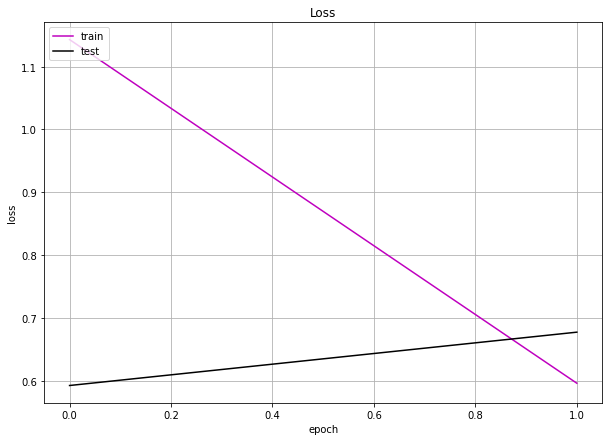

In [40]:
# Train and Validation Loss
rcParams['figure.figsize'] = 10,7
plt.grid('True')
plt.plot(results.history['loss'], color='m')
plt.plot(results.history['val_loss'], color='k')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()